# Part 1: Calculating RE24 and LW

We're going to use this package lme4 in Part 2 of today's R tutorial. Let's go ahead and install it at the beginning. It can take a few minutes to install, so run this block of code and then start reading the tutorial.

In [38]:
install.packages('lme4')                                                                          #

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Start by loading the two CSV data files from Canvas into our R session.

In [39]:
event <- read.csv("event.csv")                                                                    #
player <- read.csv("player.csv")                                                                  #

Our goal is to calculate RE24 and LW for each batter. First, we need to calculate base-out run expectancy. To set up our Markov chain, we create character strings encoding the state before and after each plate appearance.

In [40]:
data <- event |>                                                                                  #
  dplyr::mutate(                                                                                  #
    pre_runner_1b = 1 * !is.na(pre_runner_1b_id),                                                 #
    pre_runner_2b = 1 * !is.na(pre_runner_2b_id),                                                 #
    pre_runner_3b = 1 * !is.na(pre_runner_3b_id),                                                 #
    post_runner_1b = 1 * !is.na(post_runner_1b_id),                                               #
    post_runner_2b = 1 * !is.na(post_runner_2b_id),                                               #
    post_runner_3b = 1 * !is.na(post_runner_3b_id)                                                #
  ) |>                                                                                            #
  dplyr::mutate(                                                                                  #
    pre_state = paste0(                                                                           #
      1 * !is.na(pre_runner_1b_id),                                                               #
      1 * !is.na(pre_runner_2b_id),                                                               #
      1 * !is.na(pre_runner_3b_id),                                                               #
      pre_outs                                                                                    #
    ),                                                                                            #
    post_state = ifelse(                                                                          #
      test = post_outs == 3,                                                                      #
      yes = paste0("end", runs_on_event),                                                         #
      no = paste0(                                                                                #
        1 * !is.na(post_runner_1b_id),                                                            #
        1 * !is.na(post_runner_2b_id),                                                            #
        1 * !is.na(post_runner_3b_id),                                                            #
        post_outs                                                                                 #
      )                                                                                           #
    )                                                                                             #
  )                                                                                               #

Next we need the transition probabilities of the Markov chain. We will use the empirical transition probabilities, so we need to calculate the frequency with which we observe each state transition. Below, we count the number of transitions observed between each pair of states.

During this step, we will also calculate the reward for each transition between two states.

In [41]:
transition_count <- data |>                                                                       #
  dplyr::mutate(                                                                                  #
    reward = ifelse(                                                                              #
      test = post_outs == 3,                                                                      #
      yes = runs_on_event,                                                                        #
      no = (pre_runner_1b + pre_runner_2b + pre_runner_3b + pre_outs) + 1 -                       #
        (post_runner_1b + post_runner_2b + post_runner_3b + post_outs)                            #
    )                                                                                             #
  ) |>                                                                                            #
  dplyr::count(pre_state, post_state, reward)                                                     #

head(transition_count)                                                                            #

,pre_state,post_state,reward,n
,<chr>,<chr>,<dbl>,<int>
1,0000,0000,1,1261
2,0000,0001,0,27575
3,0000,0010,0,194
4,0000,0100,0,1796
5,0000,1000,0,9253
6,0001,0001,1,843


To convert counts into probabilities, we divide each transition count by the number of total transitions out of that starting state.

In [42]:
transition_prob <- transition_count |>                                                            #
  dplyr::group_by(pre_state) |>                                                                   #
  dplyr::mutate(                                                                                  #
    n_total = sum(n),                                                                             #
    prob = n / n_total                                                                            #
  ) |>                                                                                            #
  dplyr::ungroup() |>                                                                             #
  dplyr::select(pre_state, post_state, prob, reward)                                              #

head(transition_prob)                                                                             #

pre_state,post_state,prob,reward
<chr>,<chr>,<dbl>,<dbl>
0000,0000,0.03146286,1
0000,0001,0.68801617,0
0000,0010,0.00484044,0
0000,0100,0.04481150,0
0000,1000,0.23086903,0
0001,0001,0.02879197,1


With our Markov chain now defined (with states and transition probabilities), we now turn to the Bellman equation and value iteration. First, let's initiate the value of each state to zero.

In [43]:
value <- transition_count |>                                                                      #
  dplyr::distinct(state = pre_state, value = 0)                                                   #

head(value)                                                                                       #

,state,value
,<chr>,<dbl>
1,0000,0
2,0001,0
3,0002,0
4,0010,0
5,0011,0
6,0012,0


Below, we iteratively apply the update step from the Bellman equation until the estimated run expectancies converge. We use a while loop to iterate until the change in run expectancy is very small. It happens very quickly!

In [44]:
change <- Inf                                                                                     #
threshold <- 0.001                                                                                #

while(change > threshold) {                                                                       #

  value_new <- transition_prob |>                                                                 #
    dplyr::left_join(value, by = c("post_state" = "state")) |>                                    #
    dplyr::group_by(state = pre_state) |>                                                         #
    dplyr::summarize(value = sum(prob * (reward + dplyr::coalesce(value, 0))))                    #

  change <- value |>                                                                              #
    dplyr::left_join(value_new, by = "state", suffix = c("_old", "_new")) |>                      #
    with(sum(abs(value_new - value_old)))                                                         #

  print(change)   # just to see how quickly the convergence happens                               #

  value <- value_new                                                                              #
}                                                                                                 #

[1] 8.787837
[1] 5.787973
[1] 3.667325
[1] 2.181085
[1] 1.166552
[1] 0.5592613
[1] 0.2475806
[1] 0.1048928
[1] 0.04300104
[1] 0.01717402
[1] 0.006715074
[1] 0.002580105
[1] 0.0009769382


## Exercises

EXERCISE #1

Calculate the linear weight of each different outcome in the `event` column.

Recall the definition of outcome linear weight:
$$\ell(o) = \frac{
  \sum_{i = 1}^n \mathbb{I}\{o_i = o\} \cdot (r_i + v(s_i') - v(s_i))
}{
  \sum_{i = 1}^n \mathbb{I}\{o_i = o\}
}.
$$

To see a hint, double click **here**.
<!---
Start with the `data_with_state` dataframe, and join with the `value` dataframe twice: first to get the value of the pre state and second to get the value of the post state.
--->

In [45]:
data_with_re <- data |>                                                                           #
  dplyr::left_join(value, by = c("pre_state" = "state")) |>                                       #
  dplyr::rename(pre_run_exp = value) |>                                                           #
  dplyr::left_join(value, by = c("post_state" = "state")) |>                                      #
  dplyr::rename(post_run_exp = value)                                                             #

linear_weight <- data_with_re |>                                                                  #
  dplyr::group_by(event) |>                                                                       #
  dplyr::summarize(                                                                               #
    linear_weight = mean(runs_on_event + dplyr::coalesce(post_run_exp, 0) - pre_run_exp),         #
    .groups = "drop"                                                                              #
  )                                                                                               #

linear_weight |>                                                                                  #
  dplyr::arrange(-linear_weight)                                                                  #

event,linear_weight
<chr>,<dbl>
Home Run,1.40382252
Triple,1.04138102
Wild Pitch,0.81441234
Double,0.76448630
Fielders Choice,0.72440177
Single,0.47329651
Field Error,0.44983782
Catcher Interference,0.36111532
Hit By Pitch,0.35759654


EXERCISE #2

Calculate PA, RE24 and LW for all batters.

$$
\begin{split}
  \mbox{PA}(b) &= \sum_{i = 1}^n \mathbb{I}\{b_i = b\}\\
  \mbox{RE24}(b) &= \sum_{i = 1}^n \mathbb{I}\{b_i = b\} \cdot (r_i + v(s_i') - v(s_i))\\
  \mbox{LW24}(b) &= \sum_{i = 1}^n \mathbb{I}\{b_i = b\} \cdot \ell(o_i)
\end{split}
$$

In [46]:
batter_metrics <- data_with_re |>                                                                 #
  dplyr::left_join(linear_weight, by = "event") |>                                                #
  dplyr::transmute(                                                                               #
    batter_id,                                                                                    #
    re24 = runs_on_event + dplyr::coalesce(post_run_exp, 0) - pre_run_exp,                        #
    lw = linear_weight,                                                                           #
    residual = re24 - lw                                                                          #
  )                                                                                               #

batter_summary <- batter_metrics |>                                                               #
  dplyr::group_by(batter_id) |>                                                                   #
  dplyr::summarize(                                                                               #
    pa = dplyr::n(),                                                                              #
    re24 = sum(re24),                                                                             #
    lw = sum(lw),                                                                                 #
    residual = sum(residual),                                                                     #
    re24_per_pa = re24 / pa,                                                                      #
    lw_per_pa = lw / pa,                                                                          #
    residual_per_pa = residual / pa,                                                              #
    .groups = "drop"                                                                              #
  )                                                                                               #

head(batter_summary)                                                                              #

batter_id,pa,re24,lw,residual,re24_per_pa,lw_per_pa,residual_per_pa
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
444482,232,3.027248,4.9768604,-1.9496124,0.013048483,0.021451985,-0.008403502
453568,447,2.469485,0.4755512,1.9939341,0.005524576,0.001063873,0.004460703
455117,148,-15.755141,-18.6302561,2.8751153,-0.106453654,-0.125880109,0.019426455
456781,259,7.261483,3.2319145,4.0295681,0.028036613,0.012478434,0.015558178
457705,470,9.950206,10.9297692,-0.9795631,0.021170651,0.023254828,-0.002084177
457759,477,-5.139983,-2.2223475,-2.9176354,-0.010775645,-0.004659009,-0.006116636


EXERCISE #3

Plot RE24/PA (y-axis) vs. LW/PA (x-axis) for all batters with more than 400 plate appearances.

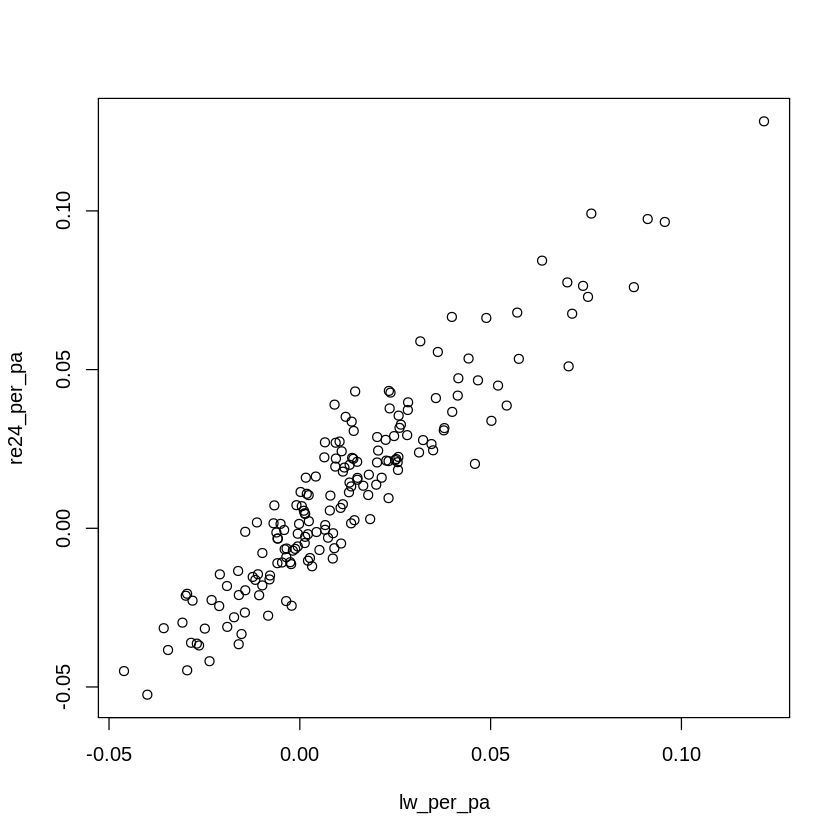

In [47]:
batter_summary |>                                                                                 #
  dplyr::filter(pa > 400) |>                                                                      #
  with(plot(lw_per_pa, re24_per_pa))                                                              #

EXERCISE #4

Among all batters with more than 400 PA, which batters have the greatest residual (RE24 - LW) / PA? Try to get batter names, not just IDs!

In [48]:
batter_summary |>                                                                                 #
  dplyr::left_join(player, by = c("batter_id" = "player_id")) |>                                  #
  dplyr::filter(pa > 400) |>                                                                      #
  dplyr::arrange(-residual_per_pa) |>                                                             #
  dplyr::select(batter_id, name_full, pa, re24_per_pa, lw_per_pa) |>                              #
  head()                                                                                          #

batter_id,name_full,pa,re24_per_pa,lw_per_pa
<int>,<chr>,<int>,<dbl>,<dbl>
686469,Vinnie Pasquantino,558,0.03896968,0.009098026
607043,Brandon Nimmo,601,0.04310496,0.014500265
664983,Jake McCarthy,435,0.05890226,0.031574086
595777,Jurickson Profar,605,0.06659267,0.039846492
687263,Zach Neto,551,0.03511884,0.012011942
592626,Joc Pederson,408,0.09916590,0.076392636


# Part 2: Regressing the Residual to the Mean

To get the most out of the information available to us in LW and RE24, we can do better than choosing between them. In this section, we perform regression to the mean on the residual RE24 -- LW. Recall the Bayesian model we have discussed in class:

$$
\begin{split}
  Z_j &\sim \mbox{Normal}(\eta_j, \sigma^2_Z / n_j) \\
  \eta_j &\sim \mbox{Normal}(0, \sigma^2_\eta)
\end{split}
$$

Conveniently, we can estimate this model in one line of code using the `lmer` (linear mixed-effects regression) function from the lme4 package you installed at the top of this notebook. This model estimates how much variance is explained by the batter (the signal) and how much is explained by noise.

In [49]:
fit <- lme4::lmer(residual ~ (1 | batter_id), data = batter_metrics)                              #

lme4::VarCorr(fit)                                                                                #

 Groups    Name        Std.Dev. 
 batter_id (Intercept) 0.0024237
 Residual              0.2350612

The table above reports the signal (`batter_id`) standard deviation and the noise (`Residual`) standard deviation. Recall that standard deviation is the square root of variance.

We can extract these numbers from the model fit using the code below.

In [50]:
var_component <- as.data.frame(lme4::VarCorr(fit))                                                #

var_signal <- var_component |>                                                                    #
  dplyr::filter(grp == "batter_id") |>                                                            #
  with(vcov)    # This is sigma^2_eta                                                             #

var_noise <- var_component |>                                                                     #
  dplyr::filter(grp == "Residual") |>                                                             #
  with(vcov)    # This is sigma^2_Z                                                               #

## Exercises

EXERCISE #1

If your goal is to estimate a batter's true talent RE24, how many plate appearances would it take before their observed RE24 becomes a better estimate than their observed LW?

Recall that this happens when $n = \sigma^2_Z / \sigma^2_\eta$.

In [51]:
var_noise / var_signal                                                                            #

[1] 9406.21

EXERCISE #2

Perform regression to the mean to estimate each batter's true talent residual (RE24 - LW) / PA.

Recall that the posterior mean of the Bayesian model is given by
$$
  \frac{n_j / \sigma^2_Z \cdot z_j}{n_j / \sigma^2_Z + 1 / \sigma^2_\eta}.
$$

In [52]:
batter_regressed <- batter_summary |>                                                             #
  dplyr::mutate(                                                                                  #
    regressed_residual_per_pa = (residual_per_pa / (var_noise / pa)) /                            #
      (pa / var_noise + 1 / var_signal)                                                           #
  )                                                                                               #

EXERCISE #3

Plot mean-regressed (RE24 -- LW) / PA on the y-axis vs. observed (RE24 -- LW) / PA on the x-axis. Use a different plotting color for players with more than 400 PA. What do you observe?

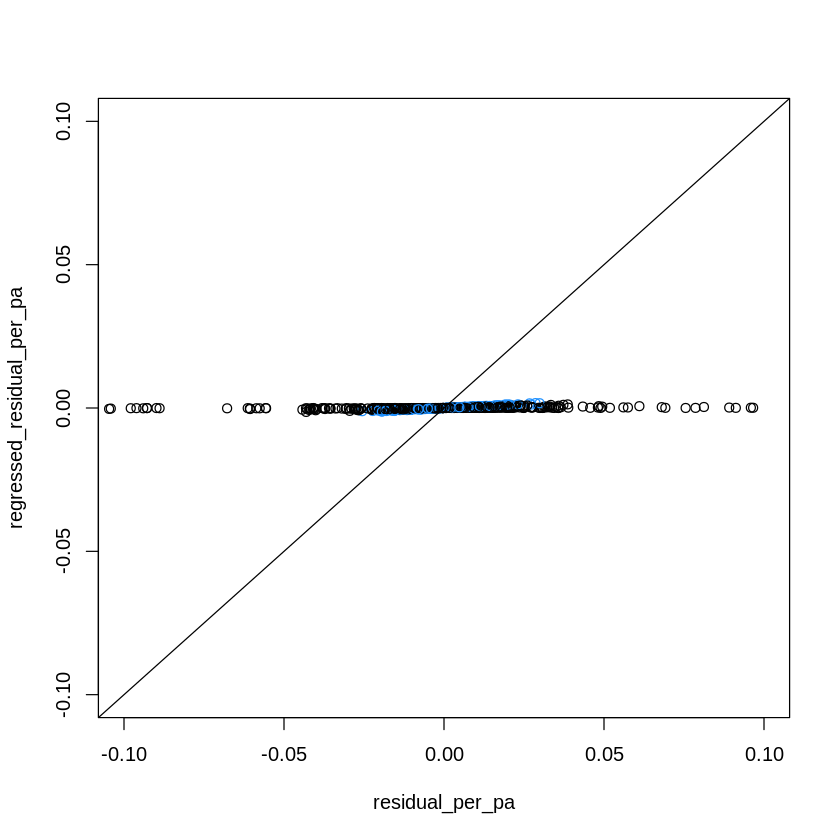

In [53]:
batter_regressed |>                                                                               #
  with(                                                                                           #
    plot(                                                                                         #
      x = residual_per_pa,                                                                        #
      y = regressed_residual_per_pa,                                                              #
      xlim = c(-0.1, 0.1),                                                                        #
      ylim = c(-0.1, 0.1),                                                                        #
      col = ifelse(pa > 400, "dodgerblue", "black")                                               #
    )                                                                                             #
  )                                                                                               #

abline(0, 1)                                                                                      #

EXERCISE #4 (Challenge)

How many plate appearances does it take before a player's observed LW / PA is a better estimator of their true talent LW / PA than simply estimating it to be zero? How about RE24 / PA?

In [54]:
# Estimate noise variance                                                                         #
variance <- batter_metrics |>                                                                     #
  dplyr::group_by(batter_id) |>                                                                   #
  dplyr::summarize(                                                                               #
    pa = dplyr::n(),                                                                              #
    re24 = var(re24),                                                                             #
    lw = var(lw)                                                                                  #
  ) |>                                                                                            #
  dplyr::filter(pa > 30) |>                                                                       #
  dplyr::summarize(                                                                               #
    re24 = weighted.mean(re24, w = pa),                                                           #
    lw = weighted.mean(lw, w = pa),                                                               #
    .groups = "drop"                                                                              #
  )                                                                                               #

# Estimate population variance in true talent                                                     #
population_variance_lw = estimate_population_variance(                                            #
  observed_value = batter_summary$lw_per_pa,                                                      #
  noise_variance = variance$lw / batter_summary$pa                                                #
)                                                                                                 #
population_variance_re24 = estimate_population_variance(                                          #
  observed_value = batter_summary$re24_per_pa,                                                    #
  noise_variance = variance$re24 / batter_summary$pa                                              #
)                                                                                                 #

# The ratio tells us the sample size threshold                                                    #
print(variance$lw / population_variance_lw)                                                       #
print(variance$re24 / population_variance_re24)                                                   #

[1] 338.9467
[1] 416.1165
